# Importing components

In [ ]:
#@title Important Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import torch
import torch.optim as optim
import nltk
nltk.download('stopwords')
nltk.download("book")
import tensorflow as tf
from numpy.lib.function_base import append
from keras.models import Sequential
from keras import layers 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from torch import nn
from torch.utils.data import DataLoader, Dataset
from google.colab import drive
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading collection 'book'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/chat80.zip.
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package conll2000 to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/conll2000.zip.
[nltk_data]    | Downloading package conll2002 to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/conll2002.zip.
[nltk_data]    | Downloading package dependency_treebank to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corp

In [ ]:
#@title Downloading dataset file
!gdown --id 1fC-NDIaVDfT8Pq5H6xPY7-n6vdMe4XYn

Downloading...
From: https://drive.google.com/uc?id=1fC-NDIaVDfT8Pq5H6xPY7-n6vdMe4XYn
To: /content/Dataset.csv
100% 480k/480k [00:00<00:00, 98.8MB/s]


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Dataset Description

In [ ]:
pd.set_option("display.max_colwidth", -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [ ]:
#@title Dataset 
df = pd.read_csv('Dataset.csv')
df.dropna(inplace = True)
df.shape
df

,Text,Sentiment
0,"Kickers on my watchlist XIDE TIT SOQ PNK CPW BPZ AJ trade method 1 or method 2, see prev posts",1
1,user: AAP MOVIE. 55% return for the FEA/GEED indicator just 15 trades for the year. AWESOME.,1
2,user I'd be afraid to short AMZN - they are looking like a near-monopoly in eBooks and infrastructure-as-a-service,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1
...,...,...
5786,"Industry body CII said #discoms are likely to suffer a net revenue loss of around Rs 30,000 crore\n\nhttps://t.co/8c6YJYJajL",-1
5787,"#Gold prices slip below Rs 46,000 as #investors book profits amid #coronavirus-led #recession fears https://t.co/fSylAJrUqv",-1
5788,Workers at Bajaj Auto have agreed to a 10% wage cut for the period between April 15 and till the lockdown is lifted. https://t.co/RgvrKPliNd,1
5789,"#Sharemarket LIVE: Sensex off day’s high, up 600 points, #Nifty tests 9,200, #TCS, private bank stocks lead\nhttps://t.co/3xgtLroKUI",1


In [ ]:
df.sample(6)

,Text,Sentiment
3930,"ed Monthly Triangle on CSN,....starting closing for profit",-1
1959,AAP Drop like a ock !,-1
5507,"Sensex, Nifty Turn Positive Amid Choppy Trade As Coronavirus Fears Linger\nhttps://t.co/HX0T49Fphj",1
5698,"Gap-Down Opening For Sensex, Nifty As Coronavirus Continues To Batter Global Markets\nhttps://t.co/yQ91f3XCNL",-1
271,ZCS almost hit my stop loss...glad to see it heading back up,1
638,Demand for breast implants at all-time highs - good or bad for economy? AGN old wallstrip too,1


In [ ]:
#@title Dataset Description
df.describe(include='all')

,Text,Sentiment
count,5791,5791.000000
unique,5791,NaN
top,"Kickers on my watchlist XIDE TIT SOQ PNK CPW BPZ AJ trade method 1 or method 2, see prev posts",NaN
freq,1,NaN
mean,NaN,0.272664
std,NaN,0.962192
min,NaN,-1.000000
25%,NaN,-1.000000
50%,NaN,1.000000
75%,NaN,1.000000


In [ ]:
print(df.groupby(['Sentiment'])['Sentiment'].count())

Sentiment
-1    2106
 1    3685
Name: Sentiment, dtype: int64


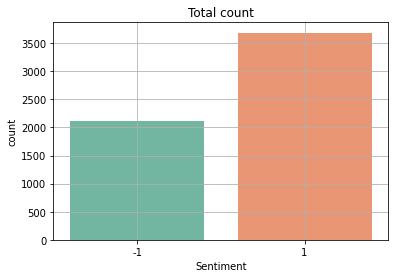

In [ ]:
#@title Dataset Outcome Graph
sns.countplot(x='Sentiment',data=df, palette='Set2')
plt.title('Total count')
plt.grid()

# Data Preprocessing

In [ ]:
# @title Stemming
ps = PorterStemmer()
all_stopwords = stopwords.words('english')
all_stopwords.remove('not')
all_stopwords.remove('no')
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'
def get_clean(x):
    x = re.sub(urlPattern,'',x)     # Removing all URls 
    x = re.sub(userPattern,'',x)    # Removing all @username.
    x = re.sub('[^a-zA-Z]', ' ',x)  # Removing all non alphabetic characters
    x = x.lower()
    x = x.split()
    x = [ps.stem(word) for word in x if not word in set(all_stopwords)]
    x = ' '.join(x)
    return x

df['Text'] = df['Text'].apply(lambda x : get_clean(x)) 

In [ ]:
df["Sentiment"] = df["Sentiment"].replace(-1,0)
df.shape
df

,Text,Sentiment
0,kicker watchlist xide tit soq pnk cpw bpz aj trade method method see prev post,1
1,user aap movi return fea geed indic trade year awesom,1
2,user afraid short amzn look like near monopoli ebook infrastructur servic,1
3,mnta,1
4,oi,1
...,...,...
5786,industri bodi cii said discom like suffer net revenu loss around rs crore,0
5787,gold price slip rs investor book profit amid coronaviru led recess fear,0
5788,worker bajaj auto agre wage cut period april till lockdown lift,1
5789,sharemarket live sensex day high point nifti test tc privat bank stock lead,1


In [ ]:
seed = 55

# Model 1 
BOW + NN

In [ ]:
torch.manual_seed(seed)

In [ ]:
cv = CountVectorizer(max_features = len(df))
X = cv.fit_transform(df['Text']).toarray()
y= df['Sentiment'].to_numpy()
X = torch.from_numpy(X)
y = torch.from_numpy(y)

In [ ]:
## Split the dataset into Training and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state = seed)

X_train = X_train.type(torch.FloatTensor)
X_test = X_test.type(torch.FloatTensor)
y_train = y_train.type(torch.FloatTensor)
y_test = y_test.type(torch.FloatTensor)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.layer_1 = nn.Linear(input_dim, 512) 
        self.layer_2 = nn.Linear(512, 128) 
        self.layer_3 = nn.Linear(128, 1)   
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout()
    
    def forward(self, x):
        x = self.layer_1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_3(x)
        logits = self.sigmoid(x)
        return logits

In [ ]:
model = NeuralNetwork(len(df))
print(model)

NeuralNetwork(
  (layer_1): Linear(in_features=5791, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
optimizer = optim.Adam(model.parameters())
loss_fn = nn.BCEWithLogitsLoss()
model = model.to(device)
loss_fn = loss_fn.to(device)

In [ ]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def trainModel(model, loss_fn, optimizer):
    model.train()
    batch = 512
    size = X_test.shape[0]
    loss = 0
    acc = 0
    for i in range(X_train.shape[0]):
      x, y = X_train[i], torch.tensor([y_train[i]], dtype=torch.float)
      pred = model(x)
      loss += loss_fn(pred,y)
      acc += binary_accuracy(pred,y)
      
      if i>0 and (i+1)%batch == 0:
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          loss = 0
          acc = 0
    print()
    return loss.item()/size, acc.item()/size

In [ ]:
from numpy.lib.function_base import append
TP=[]
TN=[]
FP=[]
FN=[]
def testModel(model, loss_fn):
    model.eval()
    size = X_test.shape[0]
    loss = 0
    acc = 0
    with torch.no_grad():
      for i in range(X_test.shape[0]):
        x, y = X_test[i], torch.tensor([y_test[i]], dtype=torch.float)
        pred = model(x)
        if( (torch.round(pred)) == 1 and y== 0) :
           FP.append(1)
        if( (torch.round(pred)) == 0 and y== 1) :
           FN.append(1)
        if( (torch.round(pred)) == 1 and y== 1) :
           TP.append(1)
        if( (torch.round(pred)) == 0 and y== 0) :
           TP.append(1)         
        loss += loss_fn(pred, y).item()
        acc += binary_accuracy(pred,y).item()
    loss /= size
    acc /= size
    return loss, acc  

In [ ]:
epochs = 10
best_valid_loss = float('inf')

# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):

    train_loss,train_acc = trainModel(model, loss_fn, optimizer)
    valid_loss, valid_acc = testModel(model, loss_fn)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'stock_sentiment.pt')
    
    print("-------Epoch ",epoch,"-------")
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tVal. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')
    
    epoch_tr_loss.append(train_loss)
    epoch_vl_loss.append(valid_loss)
    epoch_tr_acc.append(train_acc)
    epoch_vl_acc.append(valid_acc)


-------Epoch  0 -------
	Train Loss: 0.013 | Train Acc: 1.47%
	Val. Loss: 0.651 | Val. Acc: 63.85%

-------Epoch  1 -------
	Train Loss: 0.012 | Train Acc: 1.47%
	Val. Loss: 0.633 | Val. Acc: 63.85%

-------Epoch  2 -------
	Train Loss: 0.011 | Train Acc: 1.47%
	Val. Loss: 0.597 | Val. Acc: 63.85%

-------Epoch  3 -------
	Train Loss: 0.010 | Train Acc: 1.47%
	Val. Loss: 0.568 | Val. Acc: 63.85%

-------Epoch  4 -------
	Train Loss: 0.010 | Train Acc: 1.47%
	Val. Loss: 0.560 | Val. Acc: 63.85%

-------Epoch  5 -------
	Train Loss: 0.010 | Train Acc: 1.47%
	Val. Loss: 0.559 | Val. Acc: 63.85%

-------Epoch  6 -------
	Train Loss: 0.010 | Train Acc: 1.47%
	Val. Loss: 0.560 | Val. Acc: 63.93%

-------Epoch  7 -------
	Train Loss: 0.010 | Train Acc: 1.47%
	Val. Loss: 0.562 | Val. Acc: 64.02%

-------Epoch  8 -------
	Train Loss: 0.010 | Train Acc: 1.47%
	Val. Loss: 0.564 | Val. Acc: 64.02%

-------Epoch  9 -------
	Train Loss: 0.010 | Train Acc: 1.47%
	Val. Loss: 0.564 | Val. Acc: 64.02%


In [ ]:
TP=len(TP)
TN=len(TN)
FP=len(FP)
FN=len(FN)
acc=(TP+TN)/(TP+TN+FN+FP)
prec=TP/(TP+FP)
rec=TP/(TP+FN)
f1score=2*prec*rec/(prec+rec)

print("Accuracy: ",acc)
print("\nPrecision: ",prec)
print("\nRecall: ",rec)
print("\nF1 Score: ",f1score)

Accuracy:  0.775237273511648

Precision:  0.865606936416185

Recall:  0.8813143697891123

F1 Score:  0.873390036452005


# Model 2
TF-IDF + NN

In [ ]:
tfidf = TfidfVectorizer( ngram_range=(1,3), analyzer='char')
X = cv.fit_transform(df['Text']).toarray()
y= df['Sentiment'].to_numpy()

X = torch.from_numpy(X)
y = torch.from_numpy(y)

In [ ]:
## Split the dataset into Training and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state = seed)

X_train = X_train.type(torch.FloatTensor)
X_test = X_test.type(torch.FloatTensor)
y_train = y_train.type(torch.FloatTensor)
y_test = y_test.type(torch.FloatTensor)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.layer_1 = nn.Linear(input_dim, 512) 
        self.layer_2 = nn.Linear(512, 128) 
        self.layer_3 = nn.Linear(128, 1)   
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout()
        # self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.layer_1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_3(x)
        logits = self.sigmoid(x)
        return logits

In [ ]:
model = NeuralNetwork(len(df))
print(model)

NeuralNetwork(
  (layer_1): Linear(in_features=5791, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
optimizer = optim.Adam(model.parameters())
loss_fn = nn.BCEWithLogitsLoss()
model = model.to(device)
loss_fn = loss_fn.to(device)

In [ ]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def trainModel(model, loss_fn, optimizer):
    model.train()
    batch = 256
    size = X_test.shape[0]
    loss = 0
    acc = 0
    for i in range(X_train.shape[0]):
      x, y = X_train[i], torch.tensor([y_train[i]], dtype=torch.float)
      pred = model(x)
      loss += loss_fn(pred,y)
      acc += binary_accuracy(pred,y)
      
      if i>0 and (i+1)%batch == 0:
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          loss = 0
          acc = 0
    print()
    return loss.item()/size, acc.item()/size

In [ ]:
TP=[]
TN=[]
FP=[]
FN=[]
def testModel(model, loss_fn):
    model.eval()
    size = X_test.shape[0]
    loss = 0
    acc = 0  
    with torch.no_grad():
      for i in range(X_test.shape[0]):
        x, y = X_test[i], torch.tensor([y_test[i]], dtype=torch.float)
        pred = model(x)
        if( (torch.round(pred)) == 1 and y== 0) :
           FP.append(1)
        if( (torch.round(pred)) == 0 and y== 1) :
           FN.append(1)
        if( (torch.round(pred)) == 1 and y== 1) :
           TP.append(1)
        if( (torch.round(pred)) == 0 and y== 0) :
           TN.append(1)          
        loss += loss_fn(pred, y).item()
        acc += binary_accuracy(pred,y).item()
    loss /= size
    acc /= size
    return loss, acc

In [ ]:
epochs = 10
best_valid_loss = float('inf')

# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):

    train_loss,train_acc = trainModel(model, loss_fn, optimizer)
    valid_loss, valid_acc = testModel(model, loss_fn)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'stock_sentiment.pt')
    print("-------Epoch ",epoch,"-------")
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tVal. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')
    
    epoch_tr_loss.append(train_loss)
    epoch_vl_loss.append(valid_loss)
    epoch_tr_acc.append(train_acc)
    epoch_vl_acc.append(valid_acc)


-------Epoch  0 -------
	Train Loss: 0.012 | Train Acc: 1.47%
	Val. Loss: 0.643 | Val. Acc: 63.85%

-------Epoch  1 -------
	Train Loss: 0.011 | Train Acc: 1.47%
	Val. Loss: 0.586 | Val. Acc: 63.85%

-------Epoch  2 -------
	Train Loss: 0.010 | Train Acc: 1.47%
	Val. Loss: 0.560 | Val. Acc: 63.85%

-------Epoch  3 -------
	Train Loss: 0.010 | Train Acc: 1.47%
	Val. Loss: 0.558 | Val. Acc: 64.02%

-------Epoch  4 -------
	Train Loss: 0.011 | Train Acc: 1.47%
	Val. Loss: 0.559 | Val. Acc: 64.02%

-------Epoch  5 -------
	Train Loss: 0.010 | Train Acc: 1.47%
	Val. Loss: 0.562 | Val. Acc: 64.02%

-------Epoch  6 -------
	Train Loss: 0.011 | Train Acc: 1.55%
	Val. Loss: 0.561 | Val. Acc: 64.19%

-------Epoch  7 -------
	Train Loss: 0.011 | Train Acc: 1.47%
	Val. Loss: 0.563 | Val. Acc: 64.28%

-------Epoch  8 -------
	Train Loss: 0.011 | Train Acc: 1.47%
	Val. Loss: 0.564 | Val. Acc: 64.28%

-------Epoch  9 -------
	Train Loss: 0.010 | Train Acc: 1.64%
	Val. Loss: 0.565 | Val. Acc: 64.19%


In [ ]:
TP=len(TP)
TN=len(TN)
FP=len(FP)
FN=len(FN)
acc=(TP+TN)/(TP+TN+FN+FP)
prec=TP/(TP+FP)
rec=TP/(TP+FN)
f1score=2*prec*rec/(prec+rec)

print("Accuracy: ",acc)
print("\nPrecision: ",prec)
print("\nRecall: ",rec)
print("\nF1 Score: ",f1score)

Accuracy:  0.7693701466781708

Precision:  0.81391951122327

Recall:  0.8281081081081081

F1 Score:  0.8209525085404246


# Model 3
One hot embedding + CNN

In [ ]:
df = df.sample(frac = 1)
df["Sentiment"] = df["Sentiment"].replace(0,-1)
text = df['Text'].values
label = df['Sentiment'].values
text_train, text_test, label_train, label_test = train_test_split(text, label, test_size=0.20, random_state=seed)

In [ ]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(text_train)
Xcnn_train = tokenizer.texts_to_sequences(text_train)
Xcnn_test = tokenizer.texts_to_sequences(text_test)
vocab_size = len(tokenizer.word_index)+1

In [ ]:
Xcnn_train = pad_sequences(Xcnn_train, padding='post', maxlen=200)
Xcnn_test = pad_sequences(Xcnn_test, padding='post', maxlen=200)
print(Xcnn_train[0, :]) 

[   1    8 2975   43 1062  385    6  173   17   62  109  320  947  594
   93    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 200)          1120400   
                                                                 
 conv1d_3 (Conv1D)           (None, 199, 256)          102656    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 99, 256)          0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 97, 128)           98432     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 48, 128)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 45, 64)           

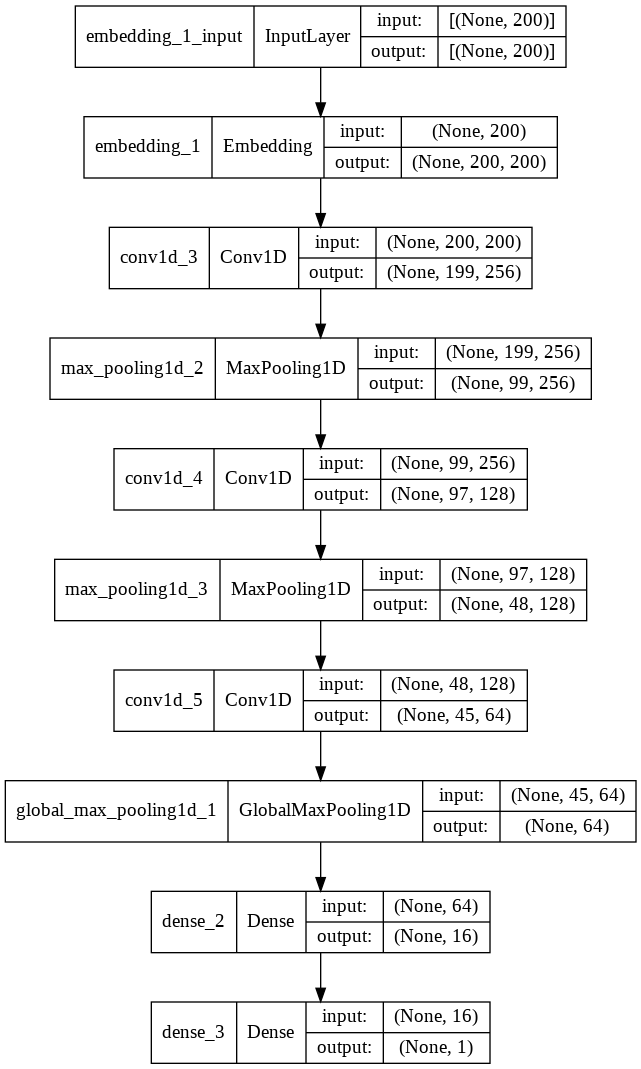

In [ ]:
torch.manual_seed(seed)
textcnnmodel = Sequential()
embedding_dim=200
textcnnmodel.add(layers.Embedding(vocab_size, embedding_dim, input_length=200))
textcnnmodel.add(layers.Conv1D(filters=256, kernel_size=2, activation='relu'))
textcnnmodel.add(layers.MaxPooling1D(pool_size = 2))
textcnnmodel.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
textcnnmodel.add(layers.MaxPooling1D(pool_size = 2))
textcnnmodel.add(layers.Conv1D(filters=64, kernel_size=4, activation='relu'))
textcnnmodel.add(layers.GlobalMaxPooling1D())
textcnnmodel.add(layers.Dense(16, activation='relu'))
textcnnmodel.add(layers.Dense(1, activation='sigmoid'))
textcnnmodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
textcnnmodel.summary() 

tf.keras.utils.plot_model(textcnnmodel, show_shapes = True, show_layer_names = True)

In [ ]:
history = textcnnmodel.fit(Xcnn_train, label_train,
                    epochs=20,
                    verbose=True,
                    validation_data=(Xcnn_test, label_test),
                    batch_size=20)
loss, accuracy = textcnnmodel.evaluate(Xcnn_train, label_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = textcnnmodel.evaluate(Xcnn_test, label_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/20
232/232 [==============================] - 13s 15ms/step - loss: -4230.8599 - accuracy: 0.1919 - val_loss: -43506.7852 - val_accuracy: 0.2761
Epoch 2/20
232/232 [==============================] - 3s 13ms/step - loss: -4252817.0000 - accuracy: 0.3247 - val_loss: -17645742.0000 - val_accuracy: 0.2657
Epoch 3/20
232/232 [==============================] - 3s 13ms/step - loss: -163319984.0000 - accuracy: 0.3262 - val_loss: -377791808.0000 - val_accuracy: 0.2657
Epoch 4/20
232/232 [==============================] - 3s 12ms/step - loss: -1602564224.0000 - accuracy: 0.3353 - val_loss: -2567475712.0000 - val_accuracy: 0.2890
Epoch 5/20
232/232 [==============================] - 3s 13ms/step - loss: -7780059136.0000 - accuracy: 0.3420 - val_loss: -9952550912.0000 - val_accuracy: 0.2761
Epoch 6/20
232/232 [==============================] - 3s 13ms/step - loss: -26590763008.0000 - accuracy: 0.3385 - val_loss: -29937510400.0000 - val_accuracy: 0.2890
Epoch 7/20
232/232 [=================

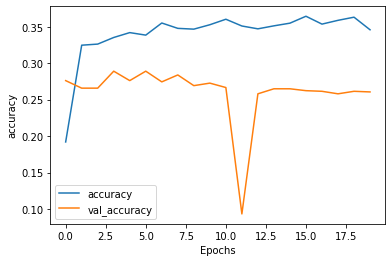

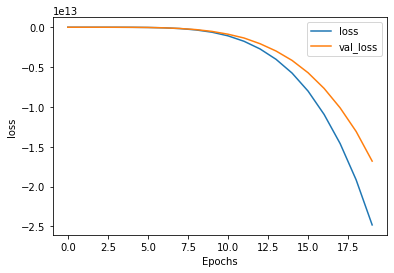

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [ ]:
y_pred = textcnnmodel.predict(Xcnn_train)
y_pred = np.where(y_pred > 0, 1, -1)
y_pred = np.reshape(y_pred, (y_pred.shape[0]))
loss, accuracy = textcnnmodel.evaluate(Xcnn_train, label_train, verbose = 1)

145/145 [==============================] - 1s 5ms/step - loss: -28419496607744.0000 - accuracy: 0.3987


In [ ]:
print('Accuracy:', accuracy_score(label_train, y_pred))
print('Precision:', precision_score(label_train, y_pred))
print('Recall:', recall_score(label_train, y_pred))
print('F1-score:', f1_score(label_train, y_pred))

Accuracy: 0.741580310880829
Precision: 0.9649947753396029
Recall: 0.6204232448773933
F1-score: 0.7552647720302595
